In [1]:
import pandas as pd
import json
import re
from sklearn.model_selection import train_test_split

# Load data
with open('devset_images_metadata.json') as f:
    metadata = json.load(f)

train_df = pd.read_csv('devset_images_gt.csv')
test_df = pd.read_csv('test.csv')

# Extract text data from JSON
texts = []
for image in metadata['images']:
    title = image.get('title', '')
    description = image.get('description', '')
    user_tags = ' '.join(image.get('user_tags', []))
    text = f"{title} {description} {user_tags}".strip()
    texts.append(text)

# Add texts to train_df
train_df['text'] = texts

# Cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply cleaning
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

train_texts = train_df['cleaned_text'].tolist()
train_labels = train_df['label'].tolist()


In [2]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess(texts, labels, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    return encodings['input_ids'], encodings['attention_mask'], labels

input_ids, attention_masks, labels = preprocess(train_texts, train_labels)


In [3]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = list(kf.split(input_ids))

# Example of how to use one split for training and validation
train_idx, val_idx = splits[0]
train_inputs = np.array(input_ids)[train_idx]
train_masks = np.array(attention_masks)[train_idx]
train_labels = np.array(labels)[train_idx]
val_inputs = np.array(input_ids)[val_idx]
val_masks = np.array(attention_masks)[val_idx]
val_labels = np.array(labels)[val_idx]


In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW

# Convert to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels, dtype=torch.long)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(val_masks)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Create DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=16)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)


C:\Users\minhd\AppData\Local\Temp\ipykernel_25740\3126032147.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
C:\Users\minhd\AppData\Local\Temp\ipykernel_25740\3126032147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
C:\Users\minhd\AppData\Local\Temp\ipykernel_25740\3126032147.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.long)
C:\Users\minhd\AppData\Local\Temp\ipykernel_25740\3126032147.py

In [18]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average train loss: {avg_train_loss}")


Average train loss: 0.32626622968889546
Average train loss: 0.21199138868938794
Average train loss: 0.14264181283810598
Average train loss: 0.09951477399744997


In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model.eval()
val_preds, val_labels = [], []

for batch in val_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    val_preds.extend(predictions.cpu().numpy())
    val_labels.extend(b_labels.cpu().numpy())

accuracy = accuracy_score(val_labels, val_preds)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.9015151515151515
Precision: 0.8419811320754716
Recall: 0.9060913705583756
F1-score: 0.8728606356968215


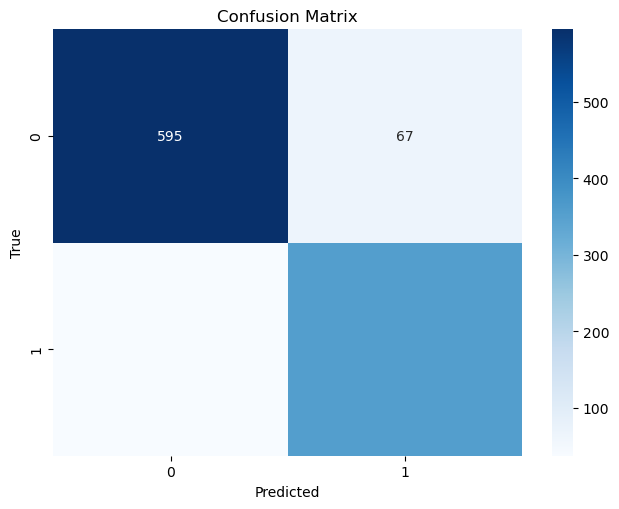

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [36]:
model.save_pretrained('bert_text_classification_model')
tokenizer.save_pretrained('bert_text_classification_tokenizer')


('bert_text_classification_tokenizer\\tokenizer_config.json',
 'bert_text_classification_tokenizer\\special_tokens_map.json',
 'bert_text_classification_tokenizer\\vocab.txt',
 'bert_text_classification_tokenizer\\added_tokens.json')

In [41]:
# Predict on test set
# Clean and preprocess test set
test_df['text'] = test_df[['description', 'user_tags','title']].apply(lambda x: ' | '.join(x.dropna()), axis=1)
test_texts = test_df['text'].apply(clean_text).tolist()
test_input_ids, test_attention_masks, _ = preprocess(test_texts, [0]*len(test_texts))

test_data = TensorDataset(torch.tensor(test_input_ids), torch.tensor(test_attention_masks))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)

# Predict
test_preds = []

model.eval()
for batch in test_dataloader:
    b_input_ids, b_input_mask = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    test_preds.extend(predictions.cpu().numpy())

test_df['label'] = test_preds
test_df['id'] = test_df['image_id']
predict = test_df[['id', 'predicted_label']]
predict.to_csv('test_predictions.csv', index=False)

In [48]:
test_df['label'] = test_preds
test_df['id'] = test_df['image_id']
predict = test_df[['id', 'label']]
predict.to_csv('test_predictions.csv', index=False)